In [1]:
!pip install -U gdown ultralytics scikit-learn albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 38.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


## 0. Download dataset

In [2]:
# # Download ICDAR 2003 dataset
# # https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=0e304164-cdee-4adf-bde4-27e406ad1241
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 60.7MB/s]


## 1. Import libraries

In [3]:
%pip install -q -U ultralytics

In [4]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/235.7 GB disk)


In [5]:
# You can run this to check if the model is working
!yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

100% 5.35M/5.35M [00:00<00:00, 97.2MB/s]
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 134k/134k [00:00<00:00, 8.97MB/s]
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 48.2ms
Speed: 11.5ms preprocess, 48.2ms inference, 705.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [6]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLO format

In [7]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [8]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [9]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


## 3. Convert to YOLO format

In [10]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [11]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

## 4. Train, val, test split

In [12]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

## 5. Save data

In [13]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [14]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

## 6. Create yaml file

In [15]:
data_yaml = {
    "path": "./datasets/yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 7. Training

In [24]:
import yaml

data_yaml = {
    "path": "/content/datasets/yolo_data",
    "train": "/content/datasets/yolo_data/train/images",
    "val": "/content/datasets/yolo_data/val/images",
    "test": "/content/datasets/yolo_data/test/images",
    "nc": 1,
    "names": ["text"]
}

# Save data.yml file
yaml_path = "/content/datasets/yolo_data/data.yml"
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f)
print(f"data.yml saved at {yaml_path}")


data.yml saved at /content/datasets/yolo_data/data.yml


In [25]:
import os

base_path = "/content/datasets/yolo_data"
for subset in ["train", "val", "test"]:
    images_path = os.path.join(base_path, subset, "images")
    labels_path = os.path.join(base_path, subset, "labels")

    print(f"\nChecking {subset} subset:")
    print(f"Images directory exists: {os.path.exists(images_path)}")
    print(f"Labels directory exists: {os.path.exists(labels_path)}")

    if os.path.exists(images_path):
        print(f"Images found: {len(os.listdir(images_path))}")
    if os.path.exists(labels_path):
        print(f"Labels found: {len(os.listdir(labels_path))}")



Checking train subset:
Images directory exists: True
Labels directory exists: True
Images found: 200
Labels found: 200

Checking val subset:
Images directory exists: True
Labels directory exists: True
Images found: 43
Labels found: 43

Checking test subset:
Images directory exists: True
Labels directory exists: True
Images found: 7
Labels found: 7


In [26]:
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolo11m.pt")

# Train the model
results = model.train(
    data="/content/datasets/yolo_data/data.yml",
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 20.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1223.66it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 181.19it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 1002.83it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 89.55it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.61G      2.056      3.009      1.831         28        640: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         43        200      0.611      0.628      0.599      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.63G      1.212      1.533      1.148         81        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.407       0.51      0.309      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.64G      1.236      1.265      1.187         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         43        200      0.357       0.68      0.492      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.56G      1.353      1.371      1.253         37        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         43        200      0.382      0.251      0.199     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.73G      1.321      1.276      1.249         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         43        200   0.000321       0.02   0.000159   4.37e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.74G      1.323      1.289      1.239         47        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         43        200    0.00283      0.085    0.00155    0.00057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       8.6G      1.389      1.313      1.285         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200     0.0371       0.11    0.00964    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       8.7G      1.334      1.187       1.22         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.117      0.275     0.0668     0.0154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.71G      1.398      1.152      1.256         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         43        200    0.00828      0.025    0.00141   0.000535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.78G      1.392      1.291      1.245         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         43        200    0.00828      0.025    0.00141   0.000535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.76G      1.273       1.22        1.2         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         43        200    0.00828      0.025    0.00141   0.000535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.71G      1.316      1.136      1.205         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         43        200     0.0423      0.035    0.00793    0.00238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.67G      1.298       1.12      1.205         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        200      0.295       0.04     0.0273       0.01



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.69G      1.222      1.091      1.178         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         43        200      0.156      0.065     0.0277     0.0136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.71G      1.276      1.021      1.156         82        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200       0.35       0.57      0.404      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.73G      1.234      1.022      1.187         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        200      0.396      0.734      0.446      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.67G      1.139     0.9735      1.133         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.502      0.755      0.518      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.62G      1.146     0.9951      1.138         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         43        200      0.598      0.775      0.663      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.75G      1.126     0.9278      1.115         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.674      0.655      0.617      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.74G      1.115     0.9211      1.117         76        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200       0.58       0.73      0.564      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.71G       1.08     0.9322      1.103         74        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200       0.77      0.802      0.797      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.74G      1.117     0.9211      1.105         93        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.661      0.735       0.67      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.75G      1.084     0.8377      1.079         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         43        200      0.739      0.681      0.692      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.77G      1.109     0.8417      1.088         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.818      0.805       0.82      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.62G       1.02     0.8072      1.062         65        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         43        200      0.776      0.866       0.85      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.72G      1.041     0.8168      1.074         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200      0.807       0.83      0.831       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.68G      1.024     0.8425      1.085         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         43        200      0.756       0.85      0.785      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.73G      1.047      0.843      1.068         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200      0.815       0.85      0.865      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.71G      1.033      0.849      1.077         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.737      0.843      0.813      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.72G     0.9724     0.7914       1.05         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.883      0.815      0.898      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.73G      1.011     0.7815      1.075         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        200      0.774       0.82      0.821      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.71G      1.003     0.7875      1.055         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.854       0.83      0.894      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.64G      1.016     0.7593      1.053         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         43        200      0.822      0.845      0.884      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.73G      1.012     0.7777      1.087         87        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         43        200      0.826      0.856      0.876      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.74G     0.9407     0.7468      1.029         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.839       0.84      0.853      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.74G     0.9739     0.7411      1.035         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


                   all         43        200      0.809      0.847      0.848      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.54G     0.9345     0.7495      1.039         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.858       0.84      0.881      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       8.7G     0.9595     0.7389      1.039         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.861      0.835      0.868       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.74G     0.9234     0.7057      1.022         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.863      0.821      0.885      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.76G     0.8884     0.6642      1.009         73        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        200      0.814      0.856      0.889      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.72G     0.8994     0.6669      1.007         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200      0.819       0.88      0.882      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.75G     0.8843     0.6739      1.002         66        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         43        200      0.844      0.835      0.884      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.75G     0.8972     0.6605      1.002         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200      0.877      0.853      0.888      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.73G     0.9002     0.6495      1.024         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.897      0.865      0.903      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.56G     0.8797     0.6662     0.9976         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.845      0.873      0.902      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.69G      0.835     0.6354     0.9877         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.845       0.84      0.866      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.72G     0.8437      0.635     0.9957         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         43        200       0.86      0.893      0.896      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.77G     0.8184     0.6156     0.9963        102        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.865      0.897      0.908      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.71G      0.823     0.6068     0.9862         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         43        200      0.883      0.867       0.91      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.68G     0.8647     0.6217     0.9859         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         43        200      0.897      0.827      0.903      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.69G     0.8345     0.6064     0.9794         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         43        200      0.877       0.84      0.879      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.62G     0.8423     0.5982     0.9983         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.887      0.864      0.893      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.69G     0.8194     0.5772     0.9766         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         43        200      0.855      0.886      0.881      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.73G     0.8266     0.5839     0.9864         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        200      0.871      0.865      0.888      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.73G     0.8044     0.5943     0.9751         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.879      0.915      0.911      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.78G      0.795     0.5961     0.9683         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.879       0.87      0.895      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.69G     0.8286     0.5848     0.9785         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        200      0.873      0.855      0.905      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.68G     0.8104     0.5734     0.9893         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.888       0.88      0.914       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.72G     0.7471     0.5622     0.9341         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.858       0.89      0.912      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.69G     0.7627     0.5446      0.959         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         43        200      0.856       0.86      0.898      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.68G     0.7665     0.5544     0.9634         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.893      0.865      0.917      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.69G     0.7768     0.5611     0.9759         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         43        200      0.912      0.845      0.915      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.69G     0.7281     0.5343     0.9535         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.874      0.868      0.894      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.64G     0.7388     0.5213     0.9524         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.843       0.93      0.908      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       8.7G     0.7432     0.5203     0.9492         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.869       0.92      0.904      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.67G     0.7569      0.529     0.9618         80        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         43        200      0.882       0.87      0.908      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.75G     0.7314      0.517     0.9516         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        200       0.88      0.915       0.91      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.62G     0.7557     0.5341     0.9591         75        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.878        0.9      0.916      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.61G     0.7078     0.5186     0.9484         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


                   all         43        200      0.846       0.88      0.904      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.77G     0.7186     0.5226     0.9451         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        200      0.851      0.888       0.91      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.73G     0.7577     0.5233     0.9712         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         43        200      0.855       0.89      0.915      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.73G      0.744     0.5417     0.9617         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.868      0.891      0.916      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.64G     0.7143     0.5311     0.9472         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        200      0.863      0.875      0.921      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.61G     0.7337     0.5324     0.9781         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.879      0.912      0.923       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.68G     0.6987     0.4934      0.945         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        200      0.876       0.92      0.926      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.69G     0.7139     0.4997     0.9363         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.885       0.89      0.921      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.71G     0.6953      0.507     0.9303         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.927      0.855      0.922      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.67G     0.7004     0.4869     0.9363         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.907       0.88      0.925      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.62G     0.6917     0.4782     0.9166         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.916      0.872      0.922      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.73G      0.657     0.4711     0.9261         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         43        200      0.831       0.91       0.92      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.61G     0.6402     0.4426     0.9269         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.865      0.896      0.912      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       8.7G     0.6694     0.4668     0.9203         94        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         43        200      0.839      0.912      0.914       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.72G     0.6653     0.4729     0.9267         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.902      0.875      0.914      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.72G     0.6573     0.4644     0.9195         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         43        200      0.904       0.91      0.928      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.72G     0.6413     0.4652     0.9263         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.909        0.9      0.929      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.72G     0.6468     0.4407     0.9194         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         43        200      0.896      0.875      0.922      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.72G     0.6697     0.4663      0.936         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.904      0.899      0.932      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.73G     0.6234      0.451     0.9158         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        200      0.887      0.915      0.928       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.56G     0.6321     0.4577     0.9112         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.914       0.89      0.923      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.74G     0.6192     0.4321     0.9041         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         43        200      0.926      0.865       0.92      0.699


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.73G     0.6821     0.5044      0.915         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


                   all         43        200      0.912      0.881       0.92      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.69G     0.6992     0.4968     0.9404         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.903       0.91      0.928      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.61G     0.6767     0.4719     0.9149         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         43        200      0.901      0.913      0.929       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.7G     0.6457     0.4622     0.9108         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.892      0.911      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.71G     0.6637     0.4793     0.9238         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         43        200      0.895      0.905       0.92      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.75G     0.6423     0.4587     0.9153         22        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.893       0.92      0.919      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.67G     0.6138     0.4245     0.8896         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         43        200      0.897       0.91       0.92      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.77G     0.6101      0.435     0.9031         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200        0.9      0.901      0.921      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.72G     0.6419     0.4632     0.9076         18        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         43        200      0.913      0.895       0.92      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.76G     0.6116     0.4334     0.8885         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.909      0.885       0.92      0.712



100 epochs completed in 0.265 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 40.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


                   all         43        200      0.909      0.899       0.93      0.736
Speed: 0.3ms preprocess, 8.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train5


## 8. Evaluation

In [28]:
from ultralytics import YOLO

model_path = "/content/runs/detect/train5/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


                   all         43        200      0.909      0.899      0.929      0.737
Speed: 0.5ms preprocess, 31.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val


## 9. Inference

In [29]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

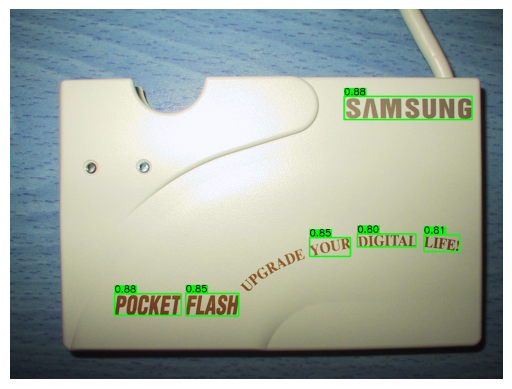

In [30]:
from ultralytics import YOLO

model_path = "/content/runs/detect/train5/weights/best.pt"
img_path = "/content/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()